In [1]:
from whoscored import *
import pandas as pd
from utils import *
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
BASE_DIR = os.path.join('..', 'data')
ENGINEERED_DIR = os.path.join(BASE_DIR, 'engineered')
SEASON_DIR = os.path.join(ENGINEERED_DIR, '2023')
MATCHES_DIR = os.path.join(SEASON_DIR, 'matches')


In [3]:
passes_df = get_all_passes_df(39, MATCHES_DIR)
passes_df

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType,match_period,angle,length
0,2.533998e+09,49.9,50.0,37.6,59.1,1232,397899.0,406255.0,Pass,Successful,FirstHalf,2.7,14.3
1,2.533998e+09,37.8,58.7,28.9,39.8,1232,406255.0,321846.0,Pass,Successful,FirstHalf,15.9,15.9
2,2.533998e+09,28.9,39.8,24.7,70.0,1232,321846.0,378598.0,Pass,Successful,FirstHalf,21.0,21.0
3,2.533998e+09,22.8,72.3,16.2,49.7,1232,378598.0,373523.0,Pass,Successful,FirstHalf,4.3,16.9
4,2.533998e+09,15.7,45.8,20.6,6.7,1232,373523.0,280413.0,Pass,Successful,FirstHalf,4.9,27.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,2.625924e+09,95.0,87.5,95.2,84.8,1232,284602.0,243212.0,Pass,Unsuccessful,SecondHalf,4.83,1.8
1001,2.625924e+09,99.5,99.5,96.7,62.1,1232,284602.0,86935.0,Pass,Unsuccessful,SecondHalf,25.6,25.6
1002,2.625924e+09,86.0,100.0,64.7,86.6,1232,93433.0,397585.0,Pass,Successful,SecondHalf,24.7,24.7
1003,2.625924e+09,66.4,77.3,64.3,58.8,1232,397585.0,401192.0,Pass,Successful,SecondHalf,4.54,12.8


In [4]:
train_test = passes_df[(passes_df['teamId'] != 1232) & (passes_df['outcomeType'] == 'Successful')].filter(['x', 'y', 'endX', 'endY','angle','length'])
train_test

,x,y,endX,endY,angle,length
12,1.2,89.0,36.0,73.5,38.0,38.0
13,13.9,90.3,2.3,71.7,3.9,17.6
23,87.9,60.6,90.6,48.2,8.9,8.9
24,99.5,99.5,83.6,94.2,3.4,17.1
27,77.1,0.0,58.0,24.4,26.3,26.3
...,...,...,...,...,...,...
907,90.4,100.0,97.0,86.9,12.4,12.4
908,96.6,88.4,90.7,85.6,3.44,6.5
936,25.1,84.6,22.7,80.7,3.95,3.7
950,53.6,59.4,49.8,71.1,8.9,8.9


In [5]:
train_test = train_test.loc[(((train_test["endX"] != 0) & (train_test["endY"] != 68)) & ((train_test["endX"] != 105) & (train_test["endY"] != 0)))]

In [6]:
def is_progressive(x, y, end_x, end_y):
    start_dist = np.sqrt((105 - x)**2 + (34 - y)**2)
    end_dist = np.sqrt((105 - end_x)**2 + (34 - end_y)**2)

    thres = 100
    if x < 52.5 and end_x < 52.5:
        thres = 30
    elif x < 52.5 and end_x >= 52.5:
        thres = 15
    elif x >= 52.5 and end_x >= 52.5:
        thres = 10
    if thres > start_dist - end_dist:
        return False
    else:
        return True

train_test["is_progressive"] = train_test.apply(lambda row : is_progressive(row['x'], row['y'], row['endX'], row['endY']), axis = 1)
train_test = train_test[train_test['is_progressive'] == True]
train_test["angle"] = np.arctan2(train_test["endY"] - train_test["y"], train_test["endX"] - train_test["x"])
train_test

C:\Users\victo\AppData\Local\Temp\ipykernel_4744\2054454535.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test["is_progressive"] = train_test.apply(lambda row : is_progressive(row['x'], row['y'], row['endX'], row['endY']), axis = 1)


,x,y,endX,endY,angle,length,is_progressive
12,1.2,89.0,36.0,73.5,-0.419024,38.0,True
23,87.9,60.6,90.6,48.2,-1.356401,8.9,True
60,39.2,79.8,56.4,76.9,-0.167034,18.2,True
119,42.8,51.9,57.6,34.3,-0.871604,19.6,True
155,68.3,96.3,82.7,72.3,-1.030377,22.2,True
...,...,...,...,...,...,...,...
675,68.5,91.3,75.8,71.6,-1.215925,15.4,True
801,33.3,68.8,68.5,85.9,0.452220,38.7,True
878,35.0,74.3,63.7,15.3,-1.118055,50.2,True
901,69.2,96.6,73.2,85.7,-1.219082,8.5,True


In [7]:
X_train = train_test.drop(['is_progressive'], axis=1)

In [8]:
X_train

,x,y,endX,endY,angle,length
12,1.2,89.0,36.0,73.5,-0.419024,38.0
23,87.9,60.6,90.6,48.2,-1.356401,8.9
60,39.2,79.8,56.4,76.9,-0.167034,18.2
119,42.8,51.9,57.6,34.3,-0.871604,19.6
155,68.3,96.3,82.7,72.3,-1.030377,22.2
...,...,...,...,...,...,...
675,68.5,91.3,75.8,71.6,-1.215925,15.4
801,33.3,68.8,68.5,85.9,0.452220,38.7
878,35.0,74.3,63.7,15.3,-1.118055,50.2
901,69.2,96.6,73.2,85.7,-1.219082,8.5


In [9]:
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=10, random_state=2147))
])

pipeline.fit(X_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=10, random_state=2147))])

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
train_labels = pipeline.predict(X_train)
X_train["cluster"] = train_labels
X_train

,x,y,endX,endY,angle,length,cluster
12,1.2,89.0,36.0,73.5,-0.419024,38.0,5
23,87.9,60.6,90.6,48.2,-1.356401,8.9,6
60,39.2,79.8,56.4,76.9,-0.167034,18.2,5
119,42.8,51.9,57.6,34.3,-0.871604,19.6,4
155,68.3,96.3,82.7,72.3,-1.030377,22.2,7
...,...,...,...,...,...,...,...
675,68.5,91.3,75.8,71.6,-1.215925,15.4,0
801,33.3,68.8,68.5,85.9,0.452220,38.7,5
878,35.0,74.3,63.7,15.3,-1.118055,50.2,4
901,69.2,96.6,73.2,85.7,-1.219082,8.5,0


In [12]:
import matplotlib.pyplot as plt

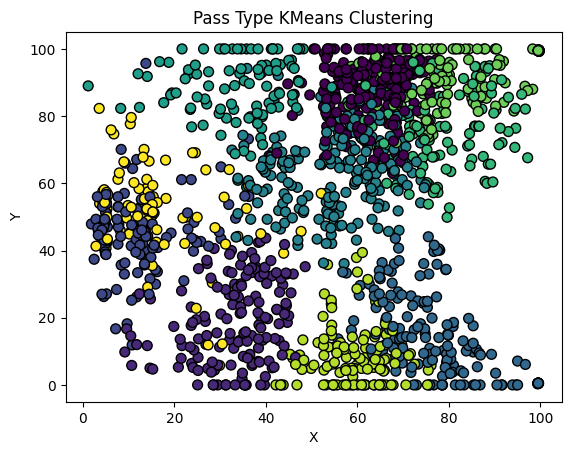

In [13]:

plt.scatter(X_train["x"], X_train["y"], c=X_train["cluster"], cmap='viridis', edgecolors='k', s=50)
plt.title('Pass Type KMeans Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [14]:
from joblib import dump, load

In [15]:
MODELS_DIR = os.path.join(BASE_DIR, 'models')
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
filename = os.path.join(MODELS_DIR,'passes_clustering.joblib')
dump(pipeline, filename)

['..\\data\\models\\passes_clustering.joblib']

In [16]:
def clustering_pipeline(df):
    model = load(filename)
    cluster_df = df.filter(['x', 'y', 'endX', 'endY','angle','length'])
    labels = model.predict(cluster_df)
    df["cluster"] = labels
    return df

In [17]:
round_match = 9
data = get_data(round_match, MATCHES_DIR)
events_dict, players_df, teams_dict = extract_data_from_dict(data)
match_passes = get_passes_df(events_dict)

home_team_id = list(teams_dict.keys())[0]  # selected home team

In [18]:
flu_passes_df = passes_df.loc[(passes_df["teamId"] == home_team_id)]
flu_passes_df["is_progressive"] = flu_passes_df.apply(lambda row : is_progressive(row['x'], row['y'], row['endX'], row['endY']), axis = 1)
flu_passes_df = flu_passes_df[flu_passes_df['is_progressive'] == True]
flu_passes_df["angle"] = np.arctan2(flu_passes_df["endY"] - flu_passes_df["y"], flu_passes_df["endX"] - flu_passes_df["x"])
flu_passes_df = clustering_pipeline(flu_passes_df)

In [19]:
flu_passes_df

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType,match_period,angle,length,is_progressive,cluster
9,2.533999e+09,13.4,16.4,59.6,10.3,1232,373523.0,416911.0,Pass,Unsuccessful,FirstHalf,-0.131275,48.7,True,1
11,2.533999e+09,77.3,29.5,93.4,36.1,1232,409247.0,406255.0,Pass,Successful,FirstHalf,0.389044,17.5,True,3
36,2.534002e+09,57.5,35.2,68.4,30.3,1232,40237.0,416913.0,Pass,Unsuccessful,FirstHalf,-0.422472,11.9,True,8
45,2.534002e+09,15.0,41.0,61.4,0.0,1232,27490.0,416911.0,Pass,Unsuccessful,FirstHalf,-0.723692,56.5,True,2
59,2.534003e+09,7.7,48.7,53.2,18.8,1232,378598.0,241824.0,Pass,Unsuccessful,FirstHalf,-0.581380,51.9,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,2.625924e+09,92.7,82.0,92.5,54.6,1232,93433.0,97262.0,Pass,Unsuccessful,SecondHalf,-1.578095,18.6,True,6
989,2.625924e+09,99.5,99.5,92.9,60.6,1232,284602.0,149572.0,Pass,Unsuccessful,SecondHalf,-1.738862,27.3,True,7
991,2.625924e+09,66.4,79.0,89.7,19.8,1232,284602.0,472116.0,Pass,Unsuccessful,SecondHalf,-1.195836,47.1,True,6
1001,2.625924e+09,99.5,99.5,96.7,62.1,1232,284602.0,86935.0,Pass,Unsuccessful,SecondHalf,-1.645523,25.6,True,7


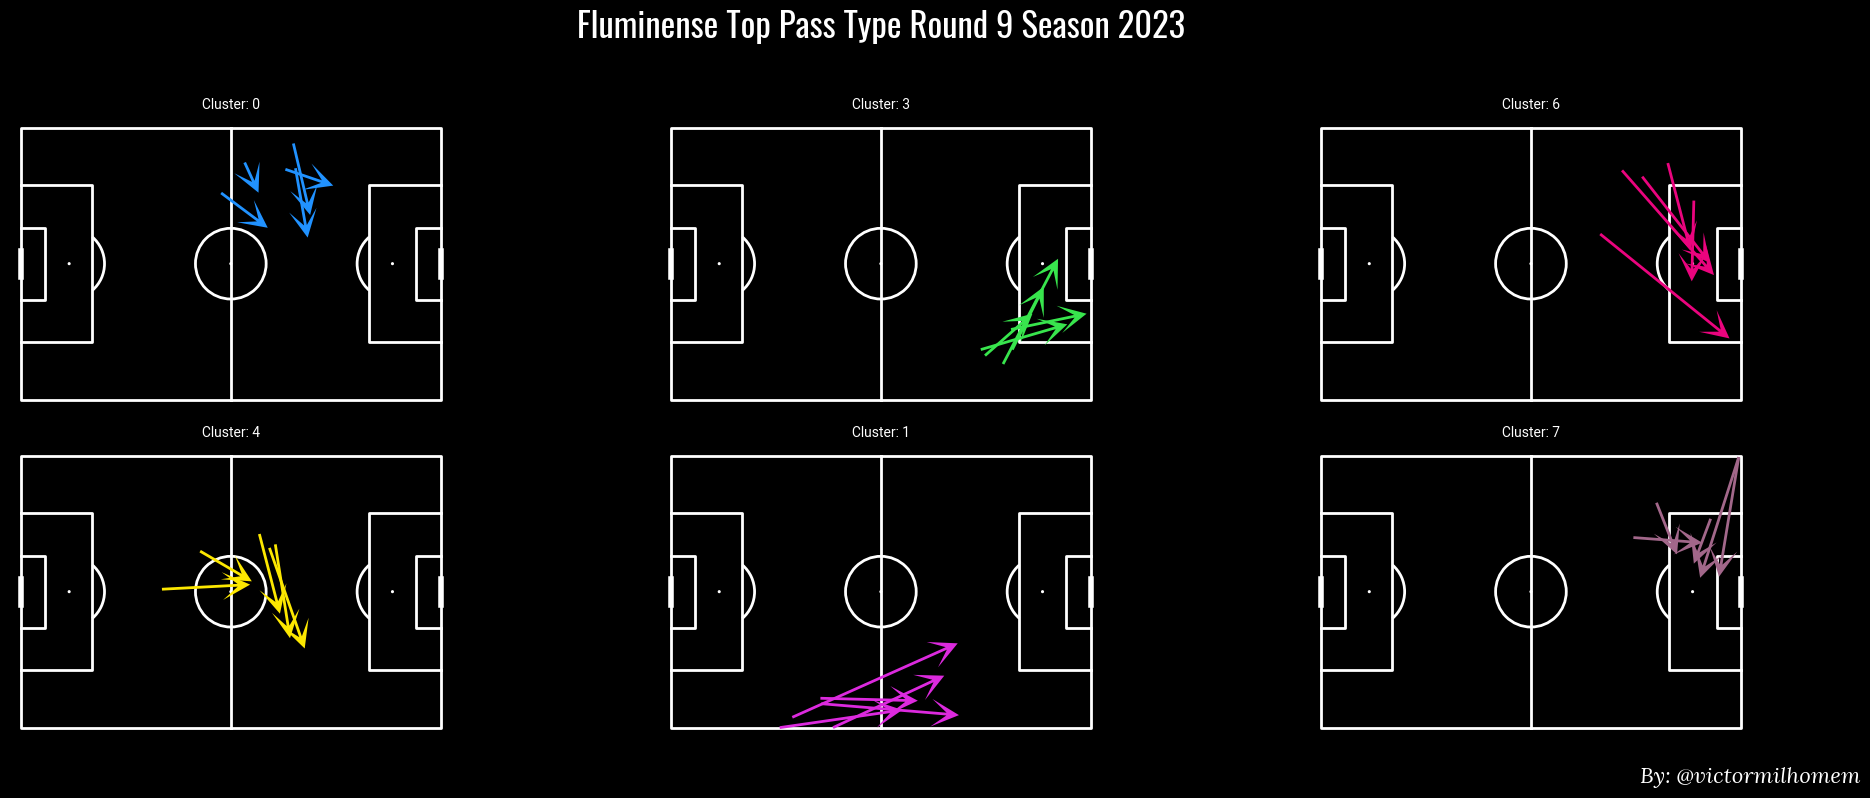

In [20]:
create_cluster_passes_map_2(flu_passes_df, f"Fluminense Top Pass Type Season 2023", credit="By: @victormilhomem")